In [2]:
# !pip install alpaca-trade-api
# !pip install requests
# !pip install pandas
# !pip install nltk
# !pip install textblob
# !pip install matplotlib
# !pip install vaderSentiment
# !pip install apscheduler
# !pip install transformers
# !pip install yfinance
# !pip install empyrical

In [3]:
import requests
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datetime import datetime, timedelta
import yfinance as yf
import alpaca_trade_api as tradeapi
import time
from apscheduler.schedulers.background import BackgroundScheduler

In [4]:
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Alpaca alpaca setup
FMP_API_KEY = os.getenv('FMP_API_KEY')
ALPACA_API_KEY = os.getenv('ALPACA_API_KEY')
ALPACA_SECRET_KEY = os.getenv('ALPCACA_SECRET_KEY')
BASE_URL='https://paper-api.alpaca.markets'
alpaca = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, base_url=BASE_URL)

## **Get Stock Symbols**

In [5]:
def get_nasdaq100_symbols():
    url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    html = requests.get(url).text
    df = pd.read_html(html)[4]  # The NASDAQ-100 table is the fourth table on the page
    return df['Ticker'].tolist()

# Step 1: Fetch Nasdaq 100 symbols
nasdaq_symbols = get_nasdaq100_symbols()


<ipython-input-5-03e3d53574e7>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(html)[4]  # The NASDAQ-100 table is the fourth table on the page


In [6]:
def get_dowjones_symbols():
    url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
    html = requests.get(url).text
    df = pd.read_html(html)[1]  # The Dow Jones table is the second table on the page
    return df['Symbol'].tolist()

# Step 1: Fetch Dow Jones symbols
dow_jones_symbols = get_dowjones_symbols()


<ipython-input-6-4aedfd7128ed>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(html)[1]  # The Dow Jones table is the second table on the page


In [7]:
# Step 1: Create dataframes for each index
nasdaq_df = pd.DataFrame({'symbol': nasdaq_symbols, 'index': 'Nasdaq 100'})
dow_jones_df = pd.DataFrame({'symbol': dow_jones_symbols, 'index': 'Dow Jones'})

# Step 2: Combine the dataframes
combined_df = pd.concat([nasdaq_df, dow_jones_df], ignore_index=True)

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load both FinBERT models
model_name_prosus = "ProsusAI/finbert"
tokenizer_prosus = AutoTokenizer.from_pretrained(model_name_prosus)
model_prosus = AutoModelForSequenceClassification.from_pretrained(model_name_prosus)
sentiment_analyzer_prosus = pipeline("sentiment-analysis", model=model_prosus, tokenizer=tokenizer_prosus)

model_name_yiyang = "yiyanghkust/finbert-tone"
tokenizer_yiyang = AutoTokenizer.from_pretrained(model_name_yiyang)
model_yiyang = AutoModelForSequenceClassification.from_pretrained(model_name_yiyang)
sentiment_analyzer_yiyang = pipeline("sentiment-analysis", model=model_yiyang, tokenizer=tokenizer_yiyang)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

## **Fetch News**

In [9]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
import requests
import yfinance as yf
import pandas as pd

# Function to fetch Alpaca news
def get_alpaca_news(symbol=None, limit=50):
    url = f"https://data.alpaca.markets/v1beta1/news?sort=desc&limit={limit}"
    if symbol:
        url += f"&symbols={symbol}"
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": ALPACA_API_KEY,
        "APCA-API-SECRET-KEY": ALPACA_SECRET_KEY
    }
    response = requests.get(url, headers=headers)
    return response.json().get('news', [])

# Function to fetch Yahoo Finance news (headlines only)
def fetch_yfinance_news(symbol):
    ticker = yf.Ticker(symbol)
    news_items = ticker.news
    news_data = []
    for article in news_items:
        news_data.append({
            'title': article.get('title', 'No title'),
            'publisher': article.get('publisher', 'Unknown publisher'),
            'link': article.get('link', ''),
            'date': article.get('providerPublishTime', None)  # Use None if date is missing
        })
    return news_data

# Function to filter articles within the date range
def filter_articles_by_date(news_items, start_date, end_date):
    filtered_news = []
    for article in news_items:
        article_date = article.get('date')
        if article_date:
            article_date = datetime.fromtimestamp(article_date) if isinstance(article_date, (int, float)) else datetime.strptime(article_date, '%Y-%m-%dT%H:%M:%S.%fZ')
            if start_date <= article_date <= end_date:
                filtered_news.append(article)
    return filtered_news

# Function to fetch news data and perform sentiment analysis using both FinBERT models
def fetch_news_and_analyze(row, start_date, end_date):
    symbol = row['symbol']
    index_name = row['index']
    news_data = []
    print(f"Fetching news for {symbol} ({index_name})...")

    # Fetch Alpaca news
    alpaca_articles = get_alpaca_news(symbol)
    filtered_alpaca_articles = filter_articles_by_date(alpaca_articles, start_date, end_date)
    for article in filtered_alpaca_articles:
        headline = article['headline']

        # Perform sentiment analysis using both models
        sentiment_prosus = sentiment_analyzer_prosus(headline)[0]
        sentiment_yiyang = sentiment_analyzer_yiyang(headline)[0]

        news_data.append({
            'symbol': symbol,
            'index': index_name,
            'source': 'Alpaca',
            'headline': headline,
            'sentiment_prosus': sentiment_prosus['label'],
            'confidence_prosus': sentiment_prosus['score'],
            'sentiment_yiyang': sentiment_yiyang['label'],
            'confidence_yiyang': sentiment_yiyang['score'],
            'date': article['created_at']
        })

    # Fetch Yahoo Finance news
    yfinance_articles = fetch_yfinance_news(symbol)
    yfinance_articles_filtered = filter_articles_by_date(yfinance_articles, start_date, end_date)
    for article in yfinance_articles_filtered:
        headline = article['title']

        # Perform sentiment analysis using both models
        sentiment_prosus = sentiment_analyzer_prosus(headline)[0]
        sentiment_yiyang = sentiment_analyzer_yiyang(headline)[0]

        news_data.append({
            'symbol': symbol,
            'index': index_name,
            'source': 'Yahoo Finance',
            'headline': headline,
            'sentiment_prosus': sentiment_prosus['label'],
            'confidence_prosus': sentiment_prosus['score'],
            'sentiment_yiyang': sentiment_yiyang['label'],
            'confidence_yiyang': sentiment_yiyang['score'],
            'date': datetime.fromtimestamp(article['date']).strftime('%Y-%m-%d %H:%M:%S') if article['date'] else 'Unknown'
        })

    return news_data

# Gather news data using ThreadPoolExecutor for parallel processing
def gather_news_data_parallel(combined_df, start_date, end_date):
    news_data = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = executor.map(fetch_news_and_analyze, [row for _, row in combined_df.iterrows()], [start_date]*len(combined_df), [end_date]*len(combined_df))
        for result in results:
            news_data.extend(result)
    return pd.DataFrame(news_data)


In [10]:
# Define your date range
start_date = datetime.now() - pd.DateOffset(days=1)  # Last 1 day
end_date = datetime.now()

# Example usage
news_df = gather_news_data_parallel(combined_df, start_date, end_date)

# Display the DataFrame with sentiment analysis
print(news_df)

Fetching news for ADBE (Nasdaq 100)...
Fetching news for ABNB (Nasdaq 100)...
Fetching news for GOOGL (Nasdaq 100)...
Fetching news for GOOG (Nasdaq 100)...
Fetching news for AMZN (Nasdaq 100)...
Fetching news for AMD (Nasdaq 100)...
Fetching news for AEP (Nasdaq 100)...
Fetching news for AMGN (Nasdaq 100)...
Fetching news for ADI (Nasdaq 100)...
Fetching news for ANSS (Nasdaq 100)...
Fetching news for AAPL (Nasdaq 100)...
Fetching news for AMAT (Nasdaq 100)...
Fetching news for ARM (Nasdaq 100)...
Fetching news for ASML (Nasdaq 100)...
Fetching news for AZN (Nasdaq 100)...
Fetching news for TEAM (Nasdaq 100)...
Fetching news for ADSK (Nasdaq 100)...
Fetching news for ADP (Nasdaq 100)...
Fetching news for BKR (Nasdaq 100)...
Fetching news for BIIB (Nasdaq 100)...
Fetching news for BKNG (Nasdaq 100)...
Fetching news for AVGO (Nasdaq 100)...
Fetching news for CDNS (Nasdaq 100)...
Fetching news for CDW (Nasdaq 100)...
Fetching news for CHTR (Nasdaq 100)...
Fetching news for CTAS (Nasdaq 1

## **Sentiment Analysis on News**

In [11]:
def map_sentiment_to_numeric(sentiment_label):
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    return sentiment_map.get(sentiment_label.lower(), 0)  # Default to 0 if the label is not recognized

def calculate_weighted_sentiment_score(news_data):
    # Convert sentiment labels to numeric values
    news_data['numeric_prosus'] = news_data['sentiment_prosus'].apply(map_sentiment_to_numeric)
    news_data['numeric_yiyang'] = news_data['sentiment_yiyang'].apply(map_sentiment_to_numeric)

    # Calculate weighted sentiment scores by multiplying numeric sentiment by confidence
    news_data['weighted_prosus'] = news_data['numeric_prosus'] * news_data['confidence_prosus']
    news_data['weighted_yiyang'] = news_data['numeric_yiyang'] * news_data['confidence_yiyang']

    return news_data


In [12]:
def aggregate_sentiment_scores(news_data):
    # Calculate the weighted sentiment score for each company
    weighted_scores = calculate_weighted_sentiment_score(news_data)

    # Aggregate the weighted scores to get the overall sentiment score for each company
    sentiment_scores = weighted_scores.groupby('symbol').agg({
        'weighted_prosus': 'mean',
        'weighted_yiyang': 'mean'
    }).reset_index()

    # Calculate the overall sentiment score as an average of the two weighted scores
    sentiment_scores['Overall_Sentiment_Score'] = sentiment_scores[['weighted_prosus', 'weighted_yiyang']].mean(axis=1)

    return sentiment_scores[['symbol', 'Overall_Sentiment_Score']]


In [13]:
# Assuming `news_data` contains your sentiment analysis results
sentiment_scores = aggregate_sentiment_scores(news_df)

# Display the combined sentiment scores
print(sentiment_scores)


   symbol  Overall_Sentiment_Score
0    AAPL                 0.049309
1    ABNB                 0.499628
2    AMAT                 0.000000
3     AMD                -0.058514
4    AMZN                 0.056741
5     ARM                 0.000000
6    AVGO                 0.000000
7     AXP                 0.000000
8     AZN                 0.000000
9      BA                 0.499996
10   BKNG                 0.421166
11    CAT                 0.937003
12  CMCSA                 0.499999
13   COST                 0.083304
14   CPRT                -0.499649
15    CRM                 0.406857
16   CRWD                -0.946518
17    CVX                 0.499986
18    DIS                -0.982458
19   DLTR                 0.000000
20    DOW                 0.000000
21     EA                 0.758498
22   GOOG                 0.193854
23  GOOGL                 0.193854
24     HD                 0.494103
25    IBM                 0.500000
26   INTC                -0.286166
27    JNJ           

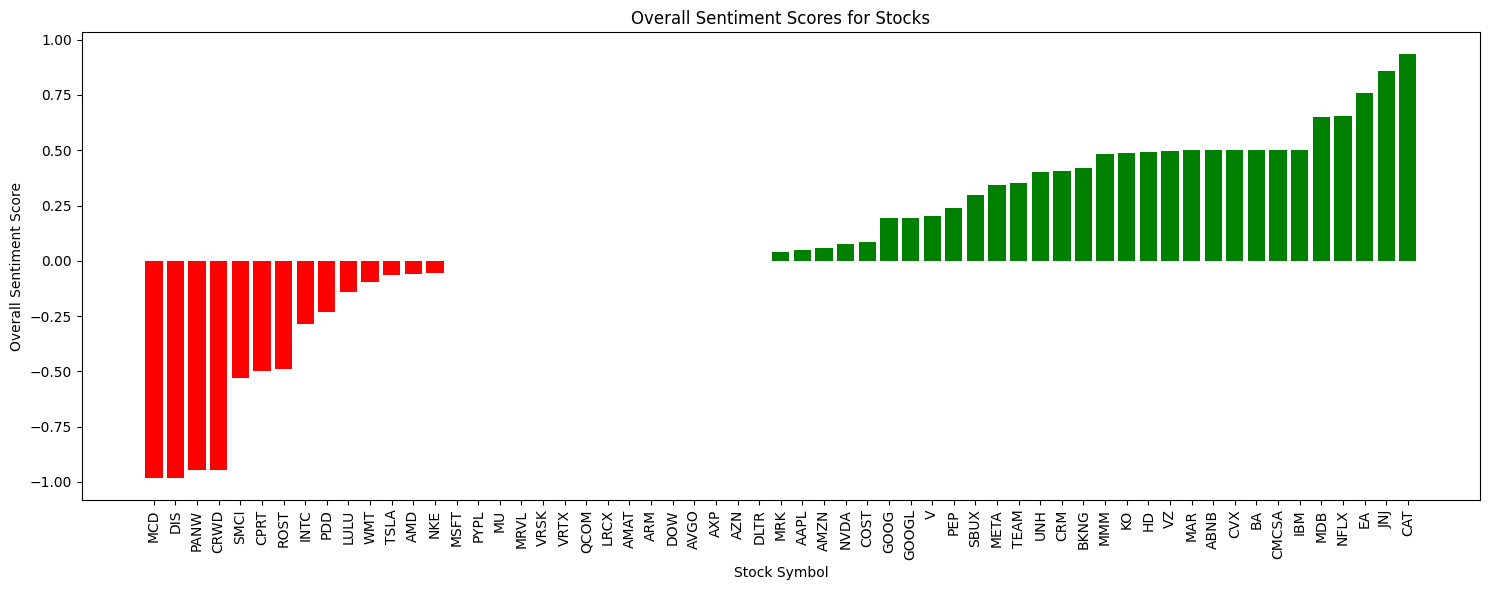

In [14]:
import matplotlib.pyplot as plt

# Assuming 'sentiment_scores' is your DataFrame with 'symbol' and 'Overall_Sentiment_Score' columns

# Sort the DataFrame by sentiment score for better visualization
sentiment_scores_sorted = sentiment_scores.sort_values('Overall_Sentiment_Score')

# Create a bar chart
plt.figure(figsize=(15, 6))
plt.bar(sentiment_scores_sorted['symbol'], sentiment_scores_sorted['Overall_Sentiment_Score'], color=['green' if score > 0 else 'red' for score in sentiment_scores_sorted['Overall_Sentiment_Score']])
plt.xlabel('Stock Symbol')
plt.ylabel('Overall Sentiment Score')
plt.title('Overall Sentiment Scores for Stocks')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This is a bar chart where each bar represents a stock symbol and its height corresponds to the overall sentiment score. Green bars indicate positive sentiment, while red bars indicate negative sentiment.

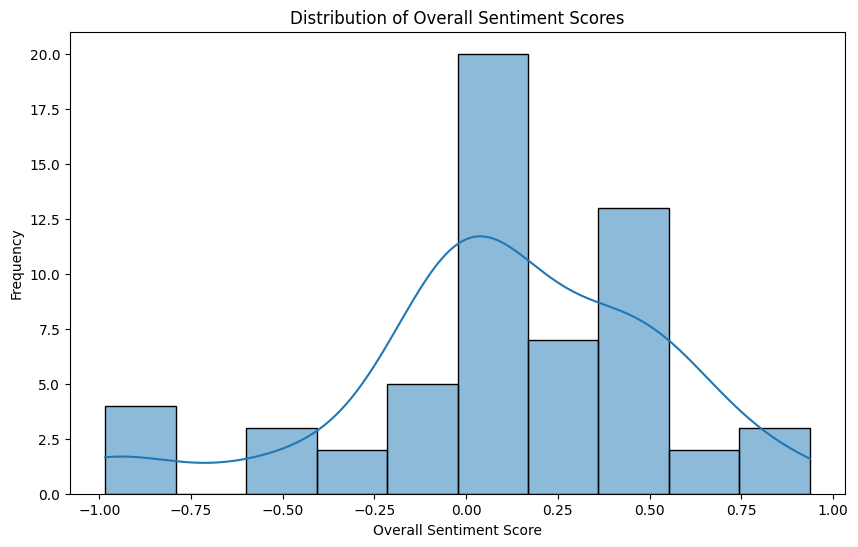

In [15]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sentiment_scores['Overall_Sentiment_Score'], bins=10, kde=True)
plt.xlabel('Overall Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Sentiment Scores')
plt.show()

This chart shows the overall sentiment score distribution, gives an idea of the overall sentiment trend.

The data shows a predominance of neutral sentiment, with a reasonable spread towards both positive and negative sentiments, but fewer extreme positive or negative scores. The distribution is somewhat skewed with a tendency towards positive sentiment.

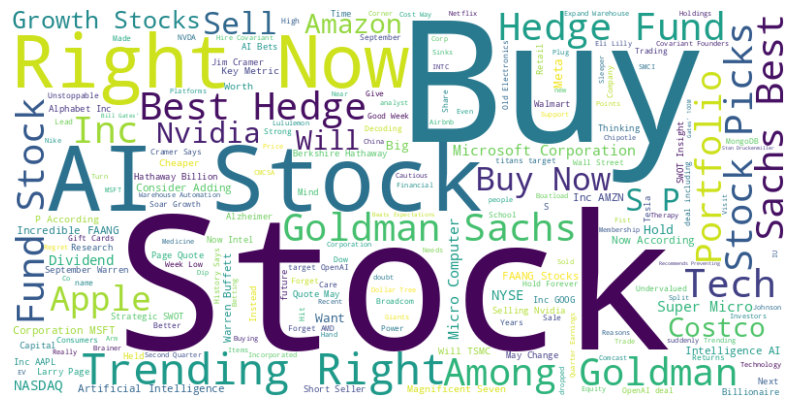

In [17]:
from wordcloud import WordCloud, STOPWORDS

# Combine all headlines into a single string
all_headlines = ' '.join(news_df['headline'].tolist())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(all_headlines)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This word cloud visually highlights the most frequent words in the news headlines, giving us insights into the topics driving the sentiment.

## **Fetch Historical data**

In [20]:
# Import TimeFrame from the Alpaca trade API
from alpaca_trade_api.rest import TimeFrame

# Function to fetch historical data using Alpaca
def fetch_historical_data_alpaca(symbols, start_date, end_date):
    historical_data = []
    for symbol in symbols:
        data = alpaca.get_bars(symbol, TimeFrame.Day, start=start_date, end=end_date).df
        data['symbol'] = symbol  # Add symbol column to distinguish data
        historical_data.append(data)
    return pd.concat(historical_data)

# Fetch historical data from Alpaca for selected companies
start_date = "2020-01-01"
end_date = "2024-07-31"
selected_companies = combined_df['symbol'].unique().tolist()
historical_data = fetch_historical_data_alpaca(selected_companies, start_date, end_date)

# Now you can use historical_data for your technical analysis


## **Technical Analysis**

In [21]:
import numpy as np
import pandas as pd

# Technical Analysis Functions
def calculate_sma(data, window=10):
    return data['close'].rolling(window=window).mean()

def generate_sma_crossover_signals(data, short_window=5, long_window=10):
    data['SMA_Short'] = calculate_sma(data, short_window)
    data['SMA_Long'] = calculate_sma(data, long_window)
    data['SMA_Crossover_Signal'] = np.where(data['SMA_Short'] > data['SMA_Long'], 1, -1)
    return data

def calculate_rsi(data, window=7):
    delta = data['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_rsi_signals(data, window=7):
    data['RSI_14'] = calculate_rsi(data)
    data['RSI_Signal'] = np.where(data['RSI_14'] < 30, 1,
                                  np.where(data['RSI_14'] > 70, -1, 0))
    return data

def calculate_macd(data):
    ema_6 = data['close'].ewm(span=6, adjust=False).mean()
    ema_13 = data['close'].ewm(span=13, adjust=False).mean()
    macd = ema_6 - ema_13
    signal = macd.ewm(span=5, adjust=False).mean()
    return macd, signal

def generate_macd_signals(data):
    data['MACD'], data['MACD_Signal'] = calculate_macd(data)
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']
    data['MACD_Signal_Strength'] = np.where(data['MACD_Histogram'] > 0, 1, 0)
    return data

# EMA Calculation and Signal
def calculate_ema(data, window=10):
    return data['close'].ewm(span=window, adjust=False).mean()

def generate_ema_signals(data, window=10):
    data[f'EMA_{window}'] = calculate_ema(data, window)
    data[f'EMA_Signal_{window}'] = np.where(data['close'] > data[f'EMA_{window}'], 1, -1)
    return data

# Bollinger Bands Calculation and Signal
def calculate_bollinger_bands(data, window=10, num_std_dev=2):
    sma = calculate_sma(data, window)
    rolling_std = data['close'].rolling(window=window).std()
    data['Bollinger_Upper'] = sma + (rolling_std * num_std_dev)
    data['Bollinger_Lower'] = sma - (rolling_std * num_std_dev)
    return data

def generate_bollinger_signals(data):
    data = calculate_bollinger_bands(data, window=10)  # Use the window argument here
    data['Bollinger_Signal'] = np.where(data['close'] < data['Bollinger_Lower'], 1,
                                        np.where(data['close'] > data['Bollinger_Upper'], -1, 0))
    return data

# Stochastic Oscillator Calculation and Signal
def calculate_stochastic_oscillator(data, window=7):
    low_min = data['low'].rolling(window=window).min()
    high_max = data['high'].rolling(window=window).max()
    stoch = 100 * (data['close'] - low_min) / (high_max - low_min)
    return stoch

def generate_stochastic_signals(data, window=7):
    data['Stochastic_%K'] = calculate_stochastic_oscillator(data, window)
    data['Stochastic_Signal'] = np.where(data['Stochastic_%K'] < 20, 1,
                                         np.where(data['Stochastic_%K'] > 80, -1, 0))
    return data

# Function to perform technical analysis
def perform_technical_analysis(historical_data):
    results = []

    for symbol in historical_data['symbol'].unique():
        stock_data = historical_data[historical_data['symbol'] == symbol].copy()

        # Generate signals for each technical indicator
        stock_data = generate_sma_crossover_signals(stock_data)
        stock_data = generate_rsi_signals(stock_data)
        stock_data = generate_macd_signals(stock_data)
        stock_data = generate_ema_signals(stock_data, window=10)  # Shorter EMA
        stock_data = generate_bollinger_signals(stock_data)  # Shorter Bollinger Band
        stock_data = generate_stochastic_signals(stock_data, window=7)  # Shorter Stochastic Oscillator

        # Create a summary of the latest signals for this stock
        signals = {
            'symbol': symbol,
            'SMA_Signal': stock_data['SMA_Crossover_Signal'].iloc[-1],
            'RSI_Signal': stock_data['RSI_Signal'].iloc[-1],
            'MACD_Signal': stock_data['MACD_Signal_Strength'].iloc[-1],
            'EMA_Signal': stock_data[f'EMA_Signal_10'].iloc[-1],
            'Bollinger_Signal': stock_data['Bollinger_Signal'].iloc[-1],
            'Stochastic_Signal': stock_data['Stochastic_Signal'].iloc[-1]
        }

        # More aggressive decision-making
        if (signals['SMA_Signal'] == 1 and
            signals['MACD_Signal'] == 1 and
            signals['RSI_Signal'] >= 0 and
            signals['Bollinger_Signal'] >= 0 and
            signals['Stochastic_Signal'] >= 0):
            signals['Final_Decision'] = 'Buy'
        elif (signals['SMA_Signal'] == -1 or
              signals['MACD_Signal'] == 0 or
              signals['RSI_Signal'] == -1 or
              signals['Bollinger_Signal'] < 0 or
              signals['Stochastic_Signal'] == -1):
            signals['Final_Decision'] = 'Sell'
        else:
            signals['Final_Decision'] = 'Hold'

        results.append(signals)

    # Convert results to a DataFrame
    signals_df = pd.DataFrame(results)
    return signals_df

# Example usage
signals_df = perform_technical_analysis(historical_data)
print(signals_df)


    symbol  SMA_Signal  RSI_Signal  MACD_Signal  EMA_Signal  Bollinger_Signal  \
0     ADBE          -1           0            1           1                 0   
1     ABNB          -1           1            0          -1                 0   
2    GOOGL          -1           1            1          -1                 0   
3     GOOG          -1           1            1          -1                 0   
4     AMZN          -1           0            1           1                 0   
..     ...         ...         ...          ...         ...               ...   
119    TRV           1          -1            1           1                 0   
120    UNH           1          -1            0           1                 0   
121     VZ          -1          -1            1           1                 0   
122      V          -1           0            1           1                 0   
123    WMT          -1           1            0          -1                 0   

     Stochastic_Signal Fina

## **Merging the signals from technical analysis with sentiment scores**

In [22]:
# Perform a left join to add the overall_sentiment_score to the signals_df
signals_df = signals_df.merge(sentiment_scores[['symbol', 'Overall_Sentiment_Score']], on='symbol', how='left')

In [23]:
# Fill missing sentiment scores with 0 (neutral sentiment)
signals_df['Overall_Sentiment_Score'].fillna(0, inplace=True)

# Rename the 'Final_Decision' column to 'Technical_Analysis_Results'
signals_df.rename(columns={'Final_Decision': 'Technical_Analysis_Results'}, inplace=True)

# Display the combined DataFrame
print(signals_df)

    symbol  SMA_Signal  RSI_Signal  MACD_Signal  EMA_Signal  Bollinger_Signal  \
0     ADBE          -1           0            1           1                 0   
1     ABNB          -1           1            0          -1                 0   
2    GOOGL          -1           1            1          -1                 0   
3     GOOG          -1           1            1          -1                 0   
4     AMZN          -1           0            1           1                 0   
..     ...         ...         ...          ...         ...               ...   
119    TRV           1          -1            1           1                 0   
120    UNH           1          -1            0           1                 0   
121     VZ          -1          -1            1           1                 0   
122      V          -1           0            1           1                 0   
123    WMT          -1           1            0          -1                 0   

     Stochastic_Signal Tech

## **Final Decision for trading strategy**

In [24]:
# Define the rules for combining sentiment and technical analysis results
def categorize_final_decision(row):
    sentiment = row['Overall_Sentiment_Score']
    technical = row['Technical_Analysis_Results']

    # Scenario when technical analysis says Sell, but sentiment is high
    if technical == 'Sell' and sentiment > 0.5:
        # Check other indicators, like RSI_Signal, MACD_Signal, and Bollinger_Signal
        if (row['RSI_Signal'] > 0) or (row['MACD_Signal'] > 0) or (row['Bollinger_Signal'] >= 0):
            return 'Buy'
        else:
            return 'No Action'

    # Adjusted sentiment thresholds
    if technical == 'Buy' and sentiment >= 0.4:
        return 'Strong Buy'
    elif technical == 'Buy' and sentiment >= 0:
        return 'Buy'
    elif technical == 'Sell' and sentiment < -0.1:
        return 'Strong Sell'
    elif technical == 'Sell' and sentiment < 0:
        return 'Sell'
    else:
        return 'No Action'

# Apply the function to create the final decision column
signals_df['Final_Decision'] = signals_df.apply(categorize_final_decision, axis=1)

# Display the updated DataFrame with the new Final_Decision column
print(signals_df)


    symbol  SMA_Signal  RSI_Signal  MACD_Signal  EMA_Signal  Bollinger_Signal  \
0     ADBE          -1           0            1           1                 0   
1     ABNB          -1           1            0          -1                 0   
2    GOOGL          -1           1            1          -1                 0   
3     GOOG          -1           1            1          -1                 0   
4     AMZN          -1           0            1           1                 0   
..     ...         ...         ...          ...         ...               ...   
119    TRV           1          -1            1           1                 0   
120    UNH           1          -1            0           1                 0   
121     VZ          -1          -1            1           1                 0   
122      V          -1           0            1           1                 0   
123    WMT          -1           1            0          -1                 0   

     Stochastic_Signal Tech

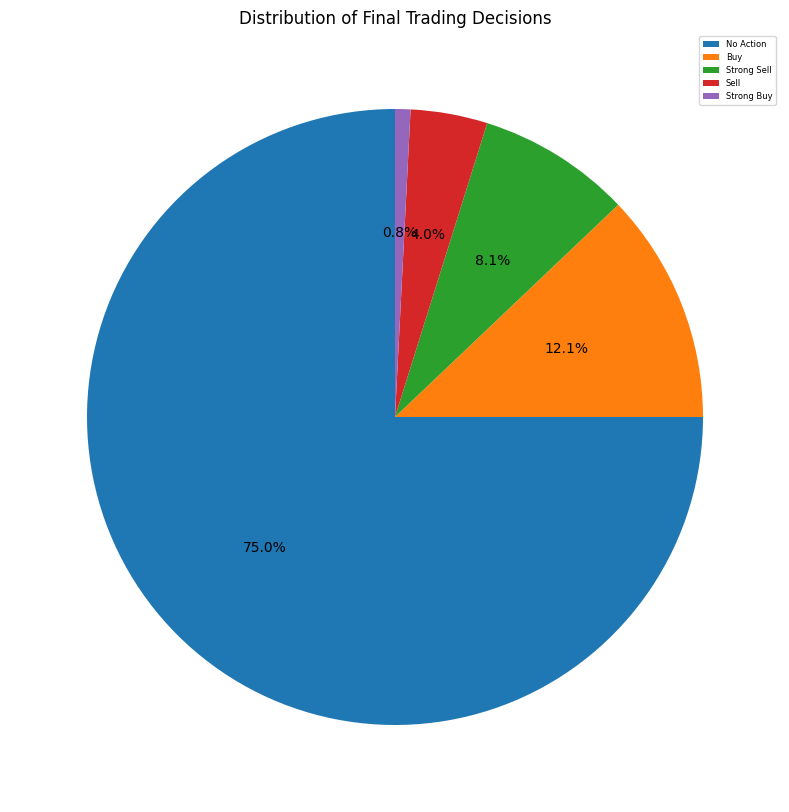

In [49]:
import matplotlib.pyplot as plt

decision_counts = signals_df['Final_Decision'].value_counts()

plt.figure(figsize=(15, 10))
plt.pie(decision_counts.values, autopct='%1.1f%%', startangle=90)  # Removed labels from pie chart
plt.title('Distribution of Final Trading Decisions')
plt.legend(decision_counts.index, loc='best', fontsize=6)  # Legend now provides labels
plt.show()

# Execution of the trading strategy

In [25]:
# Function to retrieve current positions (your portfolio)
def get_portfolio():
    positions = alpaca.list_positions()
    portfolio = {}
    for position in positions:
        symbol = position.symbol
        qty = position.qty
        avg_price = position.avg_entry_price
        current_price = position.current_price
        portfolio[symbol] = {
            'quantity': qty,
            'average_price': avg_price,
            'current_price': current_price
        }
    return portfolio


# Function to extract symbols from the portfolio dictionary
def get_portfolio_symbols(portfolio):
    return list(portfolio.keys())


In [26]:
import requests

# Fetch latest stock quotes from FMP
def fetch_stock_quotes(symbols, api_key):
    url = f'https://financialmodelingprep.com/api/v3/quote/{",".join(symbols)}?apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching stock quotes: {response.status_code}")
        return []

In [27]:
# Function to make trading decisions
def make_trade_decision(symbol, action, qty):
    try:
        if action == 'buy' and qty > 0:
            alpaca.submit_order(
                symbol=symbol,
                qty=qty,
                side='buy',
                type='market',
                time_in_force='gtc'
            )
            print(f"Buying {qty} shares of {symbol}")
        elif action == 'sell' and qty > 0:
            alpaca.submit_order(
                symbol=symbol,
                qty=qty,
                side='sell',
                type='market',
                time_in_force='gtc'
            )
            print(f"Selling {qty} shares of {symbol}")
    except Exception as e:
        print(f"Error placing order: {e}")

# Function to check if you own a stock
def check_if_own_stock(symbol, portfolio):
    return symbol in portfolio

In [28]:
# Function to execute the trading strategy
def execute_strategy(signals_df, portfolio, total_daily_budget=10000):
    symbols = signals_df['symbol'].tolist()
    quotes = fetch_stock_quotes(symbols, FMP_API_KEY)

    if not quotes:
        print("No quotes fetched, skipping trade execution.")
        return

    # Filter for stocks with a buy or strong buy signal
    buy_signals = signals_df[signals_df['Final_Decision'].isin(['Buy', 'Strong Buy'])]
    if buy_signals.empty:
        print("No buy signals today.")
        return

    # Divide the daily budget equally among all buy signals
    individual_budget = total_daily_budget / len(buy_signals)

    for i, row in buy_signals.iterrows():
        symbol = row['symbol']
        final_decision = row['Final_Decision']

        # Get the latest price
        quote = next((q for q in quotes if q['symbol'] == symbol), None)
        if quote is None:
            print(f"No quote available for {symbol}, skipping.")
            continue

        price = quote['price']
        qty = int(individual_budget / price)  # Calculate quantity based on the allocated budget

        if qty <= 0:
            print(f"Not enough budget to buy even one share of {symbol}. Skipping.")
            continue

        # Check if the stock is already in the portfolio
        own_stock = check_if_own_stock(symbol, portfolio)

        if own_stock:
            # If you already own the stock
            if final_decision == 'Strong Buy':
                print(f"Already own {symbol}. Consider buying more.")
                make_trade_decision(symbol, 'buy', qty)
            elif final_decision == 'Sell' or final_decision == 'Strong Sell':
                print(f"Selling {symbol} based on {final_decision}.")
                make_trade_decision(symbol, 'sell', qty)
        else:
            # If you do not own the stock
            if final_decision == 'Buy' or final_decision == 'Strong Buy':
                print(f"{final_decision} signal for {symbol}. Buying it.")
                make_trade_decision(symbol, 'buy', qty)

## **Backtest strategy**

In [35]:
import pandas as pd
import numpy as np
import empyrical as ep

def backtest_strategy(historical_data, signals_df):
    portfolio = {}  # To track holdings
    portfolio_values = [100000]  # Start with an initial capital of $10,000

    # Iterate through historical data, aligned with signals
    for index, row in historical_data.iterrows():
        date = row.index  # Assuming your date column is named 'timestamp'
        symbol = row['symbol']
        close_price = row['close']

        # Check if there's a signal for this stock on this date
        signal_row = signals_df[signals_df['symbol'] == symbol]
        if not signal_row.empty:
            decision = signal_row['Final_Decision'].iloc[0]

            if decision in ['Buy', 'Strong Buy']:
                # Simulate buying
                if symbol not in portfolio:
                    affordable_qty = int(portfolio_values[-1] / (2 * close_price))  # Use half the current portfolio value to buy
                    if affordable_qty > 0:
                        portfolio[symbol] = {'qty': affordable_qty, 'buy_price': close_price}
                        portfolio_values[-1] -= affordable_qty * close_price  # Deduct purchase cost

            elif decision in ['Sell', 'Strong Sell'] and symbol in portfolio:
                # Simulate selling
                qty = portfolio[symbol]['qty']
                buy_price = portfolio[symbol]['buy_price']
                profit = qty * (close_price - buy_price)
                portfolio_values[-1] += qty * close_price  # Add sale proceeds
                del portfolio[symbol]  # Remove from portfolio

        # Update portfolio value if holding positions
        current_value = portfolio_values[-1]
        for symbol, holding in portfolio.items():
            current_value += holding['qty'] * close_price
        portfolio_values.append(current_value)

    # Calculate performance metrics
    returns = ep.simple_returns(portfolio_values)
    total_return = ep.cum_returns_final(returns)
    annualized_return = ep.annual_return(returns)
    sharpe_ratio = ep.sharpe_ratio(returns)
    max_drawdown = ep.max_drawdown(returns)

    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    return portfolio_values

# Assuming 'historical_data' and 'signals_df' are already defined
portfolio_values = backtest_strategy(historical_data, signals_df)

Total Return: 17469087040993683722743843150205067950922776893031467450368.00%
Annualized Return: 26.43%
Sharpe Ratio: 1.10
Max Drawdown: -50.00%


In [36]:
# Example usage
portfolio = get_portfolio()  # Fetch the portfolio from Alpaca
total_daily_budget = 10000  # Set your daily budget to $10,000
execute_strategy(signals_df, portfolio)


Buy signal for TEAM. Buying it.
Buying 3 shares of TEAM
Buy signal for ADSK. Buying it.
Buying 2 shares of ADSK
Buy signal for CCEP. Buying it.
Buying 7 shares of CCEP
Buy signal for EA. Buying it.
Buying 4 shares of EA
Buy signal for GILD. Buying it.
Buying 7 shares of GILD
Buy signal for IDXX. Buying it.
Buying 1 shares of IDXX
Not enough budget to buy even one share of INTU. Skipping.
Buy signal for LIN. Buying it.
Buying 1 shares of LIN
Buy signal for MDB. Buying it.
Buying 2 shares of MDB
Buy signal for MNST. Buying it.
Buying 13 shares of MNST
Not enough budget to buy even one share of NFLX. Skipping.
Not enough budget to buy even one share of REGN. Skipping.
Buy signal for CAT. Buying it.
Buying 1 shares of CAT
Buy signal for JNJ. Buying it.
Buying 3 shares of JNJ
Buy signal for JPM. Buying it.
Buying 2 shares of JPM
Strong Buy signal for CRM. Buying it.
Buying 2 shares of CRM


In [37]:
def run_daily_job():
    print(f"Running the trading strategy at {datetime.now()}")

    # Step 1: Fetch the latest news articles
    news_data = fetch_news_articles()

    # Step 2: Run sentiment analysis on the news articles
    news_data = run_sentiment_analysis(news_data)

    # Step 3: Combine sentiment scores with technical analysis
    signals_df = perform_technical_analysis(historical_data)
    signals_df = combine_sentiment_with_technical_analysis(signals_df, news_data)

    # Step 4: Execute the trading strategy
    portfolio = get_portfolio()
    execute_strategy(signals_df, portfolio)

# Initialize the scheduler
scheduler = BackgroundScheduler()

# Schedule the job to run daily at 11 AM
scheduler.add_job(run_daily_job, 'cron', hour=11, minute=0)

# Start the scheduler
scheduler.start()

# Keep the script running to allow the scheduler to work
try:
    while True:
        time.sleep(60)  # Sleep for a minute to keep the script running
except (KeyboardInterrupt, SystemExit):
    scheduler.shutdown()